
| Nome        | nUSP           | 
| ------------- |:-------------:|
| Pedro Raul Taborga da Costa | 4537076 |
| Flavio de Figueiroa Teixeira Silva | 1127072|


## Tarefas

### 0. Baixar o dataset pelo site ou pelo comando

```kaggle datasets download mlg-ulb/creditcardfraud``` 

# 1. Fazer a leitura do conjunto de dados  escolhido usando  bibliotecas prontas ou funções das linguagens de programação Python ou R, por exemplo a biblioteca Pandas do Python.

In [ ]:
import pandas as pd
dtFolder = "../../datasets/"
df = pd.read_csv(dtFolder+"creditcardfraud.zip")
cols = df.columns.tolist()
reord = [cols.pop(0),cols.pop(-2),cols.pop(-1)]
cols = reord + cols
df = df[cols]

## Pré-Rebalanceamento

In [ ]:
dfRen = df
dfRen["Class"].value_counts().plot(kind="bar", color={"green":"0","red":"1"}, title="Tipo de Transações") #lol

## Após rebalanceamento
Dentre as técnicas de rebalanceamento:

1. under sampling -> random
1. over sampling -> random, SMOTE (synthetic minority oversampling techinique)
1. hibrida -> SMOTE -> TOMEK 

Escolhemos utilizar random oversampling, visto que a perda de dados por undesampling se mostrou grande mais

In [ ]:
# Armazenando a quantidade de entradas de cada tipo de transação
count_legal, count_fraude = dfRen["Class"].value_counts()

# Separando o dataset em 2 dataframes, cada um contendo só um tipo de transação
df_legal = dfRen[dfRen["Class"] == 0].reset_index()
df_fraude = dfRen[dfRen["Class"] == 1].reset_index()

# Escolhe aleatoriamente o mesmo número que temos em fraudes dentre o total de transações legais
df_fraude_over = df_fraude.sample(count_legal, replace=True)

# Cria e exibe um dataframe a partir da junção dos 2, agora balanceados
df_balanced = pd.concat([df_legal,df_fraude_over], axis=0, ignore_index=True).drop(columns=["index"])
df_balanced["Class"].value_counts().plot(kind="bar",color={"green":"Legal","red":"Fraude"},title="Tipo de Transações")



# 4. Aplicar alguma técnica de normalização nos dados.


In [ ]:
# Normalização por MinMaxScaler, onde os valores ficarão entre 0 e 1, que será útil para algoritmos de aprendizado
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(df_balanced)
df_norm = pd.DataFrame(df_mm, columns=cols)
df_norm


In [ ]:
import seaborn as sns
corr_matrix = df_norm.corr()
sns.heatmap(corr_matrix, cmap="YlGnBu")

In [ ]:
selected = corr_matrix.applymap(lambda x : x > 0.8 and x != 1)
listaVars = []
for c in selected.columns:
    for index,values in selected[c].items():
        if values == True:
            numA = c.split("V")[1]
            numB = index.split("V")[1]
            if numB > numA:
                listaVars.append([numA,numB])
listaVars #Corresponde a dupla de atributos com uma correlação maior que 0.8


In [ ]:
from math import sqrt


def euclidiana(treino, rowTeste):
    dist = sqrt((treino[0]-rowTeste[0])**2 + (treino[1]-rowTeste[1])**2)
    return [dist,treino[2]]

def manhattan(treino, rowTeste):
    dist = abs((treino[0]-rowTeste[0])) + abs((treino[1]-rowTeste[1]))
    return [dist,treino[2]]
    

In [ ]:
def knn(treino: pd.DataFrame,teste: pd.DataFrame,k: list, distancia: str):
    resultado = pd.DataFrame(columns=["Index","K","Esperado","Calculado"])
    for i, rowTeste in teste.iterrows():
        # Representa a distância entre UMA linha de teste para todos os pontos do treino
        if distancia == "euclidiana":
            dist = treino.apply(euclidiana, axis=1, rowTeste=rowTeste, result_type="expand").rename(columns={0:"Distancia",1:"Class"})
        elif distancia == "manhattan":
            dist = treino.apply(manhattan, axis=1, rowTeste=rowTeste, result_type="expand").rename(columns={0:"Distancia",1:"Class"})
        # Organiza pela menor distancia
        dist.sort_values(by="Distancia",inplace=True)
        # Utilizamos os K valores para classificar a qual grupo o teste pertence
        for numK in k:
            # Pega o número de vizinhos desejado
            topValores = dist.head(numK)
            # Retorna a classificacao baseada no máximo da classificacao dos vizinhos
            classificacao = topValores["Class"].value_counts().idxmax() 
            # Adiciona ao dataframe de respostas
            add = {"Index":i,"K":numK, "Esperado":rowTeste["Class"],"Calculado": classificacao}
            resultado = resultado.append(add,ignore_index=True)
    return resultado, teste.shape[0], k

def porcentagemAcertos(resultados: pd.DataFrame, sizeTeste:int, kList: list, colA: str, colB: str):
    print(f"Resultados utilizando os atributos {colA} e {colB}:")
    for k in kList:
        acertos = resultados.loc[resultados["K"] == float(k)].apply(lambda x: x[2] == x[3], axis=1).sum()
        print(f"{acertos} de {sizeTeste} ({(acertos/sizeTeste)*100:.2f}%) com k = {k}")

Resultados utilizando os atributos V1 e V3:
48 de 60 (80.00%) com k = 3
48 de 60 (80.00%) com k = 7
Resultados utilizando os atributos V1 e V5:
50 de 60 (83.33%) com k = 3
49 de 60 (81.67%) com k = 7
Resultados utilizando os atributos V1 e V7:
51 de 60 (85.00%) com k = 3
50 de 60 (83.33%) com k = 7
Resultados utilizando os atributos V3 e V5:
49 de 60 (81.67%) com k = 3
49 de 60 (81.67%) com k = 7
Resultados utilizando os atributos V3 e V7:
52 de 60 (86.67%) com k = 3
49 de 60 (81.67%) com k = 7
Resultados utilizando os atributos V5 e V7:
49 de 60 (81.67%) com k = 3
49 de 60 (81.67%) com k = 7
Resultados utilizando os atributos V10 e V3:
48 de 60 (80.00%) com k = 3
52 de 60 (86.67%) com k = 7
Resultados utilizando os atributos V10 e V7:
53 de 60 (88.33%) com k = 3
53 de 60 (88.33%) com k = 7
Resultados utilizando os atributos V10 e V9:
51 de 60 (85.00%) com k = 3
53 de 60 (88.33%) com k = 7
Resultados utilizando os atributos V10 e V12:
54 de 60 (90.00%) com k = 3
53 de 60 (88.33%) com k

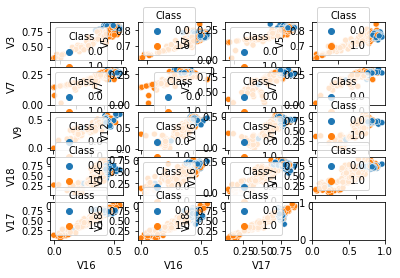

In [50]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows= 5, ncols=4)

class Helper:
    x = 0
    y = 0
    def get(self):
        res = self.x,self.y
        if self.y < 3:
            self.y += 1
        else:
            self.y = 0
            self.x += 1
        return res

helper = Helper()

for atrA,atrB in listaVars:
    colA = "V"+atrA
    colB = "V"+atrB
    df_selectedCol = pd.concat([df_norm[colA],df_norm[colB],df_norm["Class"]],axis=1)
    treino, teste = train_test_split(df_selectedCol,test_size=0.2, random_state=42) # Treino: 454904  Teste: 113726
    hx, hy = helper.get()
    sns.scatterplot(data=treino.iloc[0:500], x=colA, y=colB, hue="Class",ax= axes[hx][hy])
    explode, sizeTeste, kList = knn(treino=treino.iloc[0:500], teste=teste.iloc[0:60],k=[3,7],distancia="euclidiana")
    porcentagemAcertos(explode,sizeTeste, kList, colA, colB)

In [ ]:
fig.tight_layout()